<h1>Transfer Learning with BERT</h1>

In [22]:
# References
# https://colab.research.google.com/drive/1IubZ3T7gqD09ZIVmJapiB5MXUnVGlzwH#scrollTo=7LbVjtktg3Ln
# https://medium.com/analytics-vidhya/bert-in-keras-tensorflow-2-0-using-tfhub-huggingface-81c08c5f81d8
# https://medium.com/@brn.pistone/bert-fine-tuning-for-tensorflow-2-0-with-keras-api-9913fc1348f6

# Requirements
!pip install sentencepiece
# pip install tensorflow_hub
# pip install tensorflow
!pip install bert-for-tf2
# pip install transformers

%tensorflow_version 2.1
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import bert
import os
import math
import numpy as np
import random
import re
from datetime import datetime
from tensorflow.keras.layers import Lambda, Conv1D, Dense, Flatten, Dropout,Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
import bert
from bert import bert_tokenization 

print('Libraries loaded')


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Libraries loaded


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!ls "/content/drive/My Drive/Colab"

agr_en_train.csv  Bert-finetuning-54.ipynb  BERT.ipynb	Untitled0.ipynb


<h2>Settings</h2>

In [4]:
CLASSES = ['CAG', 'NAG', 'OAG']
MAX_LENGTH = 128
TRAIN_MODEL = True
RETRAIN_BERT = True
TRAIN_SAMPLES = 0.8
LOAD_MODEL_AND_PREDICT = True
TEXT_TO_PREDICT = ['That is a well reasoned point',
                   'This is happening in BJP ruled state. Shame on the adminstration']
DATA_FILE = '/content/drive/My Drive/Colab/agr_en_train.csv'
print('Settings set')

Settings set


<h2>Preliminary Data Exploration</h2>

<h2>Load BERT Model from Tensorflow HUB</h2>

In [36]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path,trainable=True)
print('Model Loaded')

vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)
print('Tokenizer Created')

print('Sample Tokenizer Operations')
sample_x = tokenizer.tokenize('this is a sample tokening operation. It spans multiple sentences')
sample_ids = tokenizer.convert_tokens_to_ids(sample_x)
print(sample_x)
print(sample_ids)

Model Loaded
Tokenizer Created
Sample Tokenizer Operations
['this', 'is', 'a', 'sample', 'token', '##ing', 'operation', '.', 'it', 'spans', 'multiple', 'sentences']
[2023, 2003, 1037, 7099, 19204, 2075, 3169, 1012, 2009, 14798, 3674, 11746]


Wordcount distribution


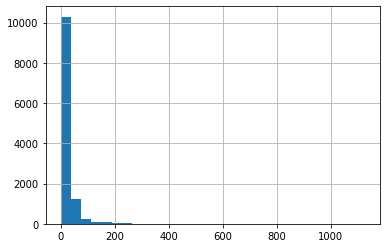

Label distribution


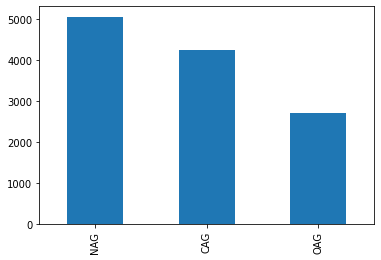

English distribution


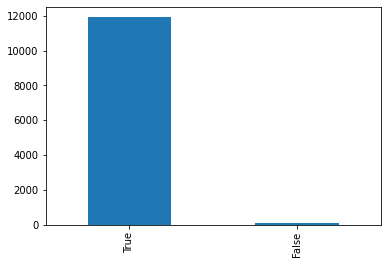

                                                   Text  ... isEnglish
41                   modi ji all the pain  nö real gain  ...     False
314   yàar my ears are bleeding stop this  get the b...  ...     False
813            रजनथ सह फर कहग क हम ननद करत ह डब मर सरकर  ...     False
830    bot powered by prince fadii  just now done  i...  ...     False
1107   bot powered by ishaq zada  see my bot speed  ...  ...     False
1441       live  nse स pehlakadam season 2 grand finale  ...     False
1462  what you should know about turkeys president r...  ...     False
1621   bot powered by prince fadii  see my bot speed...  ...     False
1704  a question of order india turkey and the retur...  ...     False
1719  अर कछ त कर खल हजड क तरह तल बजत रहन स कछ नह हग ...  ...     False

[10 rows x 4 columns]


In [6]:
def remove_URL(s):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", s)

def remove_punctuation(s):
    return re.sub(r'[^\w\s]', '', s)
    
def remove_Emoji(s):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', s)

def replace_chars(Data):
    Data['Text'] = Data['Text'].str.replace('\n',' ')
    Data['Text'] = Data['Text'].str.replace('  ',' ')
    Data['Text'] = Data['Text'].str.strip()
    Data['Text'] = Data['Text'].str.lower()
    Data['Text'] = Data['Text'].str.replace('pls','please')
    Data['Text'] = Data['Text'].str.replace('plz','please')
    Data['Text'] = Data['Text'].str.replace(' u ',' you ')
    Data['Text'] = Data['Text'].str.replace(' ur ',' your ')
    Data['Text'] = Data['Text'].str.replace(' vs ',' versus ')
    Data['Text'] = Data['Text'].str.replace(' tks ',' thanks ')
    Data['Text'] = Data['Text'].str.replace(' tkz ',' thanks ')
    Data['Text'] = Data['Text'].str.replace(' cud ',' could ')
    Data['Text'] = Data['Text'].str.replace(' b ',' be ')
    Data['Text'] = Data['Text'].str.replace(' r ',' are ')
    Data['Text'] = Data['Text'].str.replace(' gonna ',' going to ')
    Data['Text'] = Data['Text'].str.replace(' y ',' why ')
    Data['Text'] = Data['Text'].str.replace('bn ',' billion ')
    Data['Text'] = Data['Text'].str.replace('tn ',' trillion ')
    Data['Text'] = Data['Text'].str.replace('£',' pounds ')
    Data['Text'] = Data['Text'].str.replace('$',' dollars ')
    return Data

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def create_data_frame():
    data = pd.read_csv(DATA_FILE)
    data.columns = ['ID','Text','Indicator']
    data.drop(['ID'], axis='columns', inplace = True)
    
    data = replace_chars(data)
    data['Text'] = data['Text'].apply(remove_Emoji)
    data['Text'] = data['Text'].apply(remove_URL)
    data['Text'] = data['Text'].apply(remove_punctuation)
    data['Length'] = data['Text'].str.split(' ').apply(len)
    data['isEnglish'] = data['Text'].apply(isEnglish)
    return data

data = create_data_frame()
print('Wordcount distribution')
data['Length'].hist(bins=30)
plt.show()
print('Label distribution')
data['Indicator'].value_counts().plot(kind='bar')
plt.show()
print('English distribution')
data['isEnglish'].value_counts().plot(kind='bar')
plt.show()
print(data[data['isEnglish']==False][0:10])


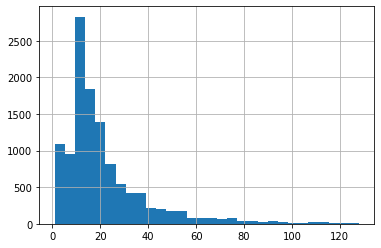

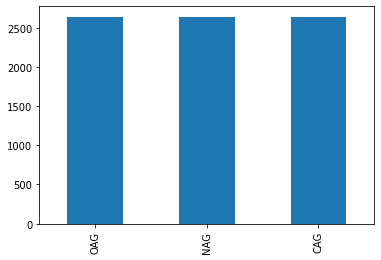

New dataset length 7926


In [7]:
def remove_too_long_samples(data):
    return data[data['Length']<=MAX_LENGTH]

def balance_samples_for_labels(data):
    oags = data[data['Indicator']=='OAG']
    length = len(oags.index)
    cags = data[data['Indicator']=='CAG'].sample(n=length,random_state=42)
    nags = data[data['Indicator']=='NAG'].sample(n=length,random_state=42)
    all_stuff = pd.concat([oags,cags,nags])
    
    #shuffle dataset
    return all_stuff.sample(n=len(all_stuff.index), random_state=42)
    
data = remove_too_long_samples(data)
data = data[data['isEnglish'] == True]
data['Length'].hist(bins=30)
plt.show()
data = balance_samples_for_labels(data)
data['Indicator'].value_counts().plot(kind='bar')
plt.show()
print('New dataset length %s' % len(data.index))


<h2>Data Processing</h2>
<p>The Bert model loaded from TF Hub expects input data in a particular format. For every text sample, three arrays are created: most importantly the sample is tokenised and then converted to Ids using BERTs tokenizer dictionary. An input mask array and sentence location (not used for classification) array are also created.

In [8]:
def Bertify(Set):
    
    tokens = map(tokenizer.tokenize, Set)
    tokens = map(lambda tok: tok[:MAX_LENGTH-2], tokens)
    tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], tokens)
    
    token_ids = map(tokenizer.convert_tokens_to_ids, tokens)
    token_ids = map(lambda tids: tids + [0] * (MAX_LENGTH - len(tids)), token_ids)
    # token_ids = map(lambda tids: np.array(tids), token_ids)
    token_ids = list(token_ids)
    token_masks =[]
    sent_segs = []
    for token_list in token_ids:
        token_masks.append([1 if x > 0 else 0 for x in token_list])
        sent_segs.append([0 for x in token_list])    
    return  [tf.cast(token_ids,tf.int32), tf.cast(sent_segs,tf.int32), tf.cast(token_masks,tf.int32)]

def preprocess_data(data): 
    #One hot encoding
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(CLASSES)
    label_ints = label_encoder.transform(data.values[:,1])
    label_ints = label_ints.reshape(len(label_ints), 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    label_onehot = onehot_encoder.fit_transform(label_ints)
    
    #Split to training and test
    train_len = int(len(data.index) * TRAIN_SAMPLES)
    
    train_set = data.values[:train_len,0]
    train_features = Bertify(train_set)
    train_labels = np.array(label_onehot[:train_len,:])
    
    test_set = data.values[train_len:,0]
    test_features = Bertify(test_set)
    test_labels = np.array(label_onehot[train_len:,:])
    
    return train_features, train_labels, test_features, test_labels

if TRAIN_MODEL:
    train_tokens, train_labels, test_tokens, test_labels = preprocess_data(data)
    print('Training data loaded')
    print(train_tokens[0:10])
    print(train_labels[0:10])
else:
    print('Training data not loaded')

Training data loaded
[<tf.Tensor: shape=(6340, 128), dtype=int32, numpy=
array([[  101,  2073,  2015, ...,     0,     0,     0],
       [  101,  2796,  4671, ...,     0,     0,     0],
       [  101,  2017,  4539, ...,     0,     0,     0],
       ...,
       [  101,  3282, 25329, ...,     0,     0,     0],
       [  101,  2293,  2017, ...,     0,     0,     0],
       [  101,  1043,  1051, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(6340, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(6340, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>]
[[1. 0. 0.]
 [0. 0. 1

<h2>Model Definition</h2>
<p>The recommended way to use BERT is via fine-tuning with minimal additional layers appended on to focus results to the task at hand (reference).
The example on tensorlow site uses the following layers: a lambda to flatten output, dropout, dense layer, dropout and a softmax dense layer to compute categorical output. https://github.com/kpe/bert-for-tf2/blob/master/examples/gpu_movie_reviews.ipynb</p>
<p>BERT Paper recommends learning rates of 5e-5, 3e-5 or 2e-5 with an Adam optimizer. I chose the smallest of these 2e-5</p>


In [46]:
METRICS = [
      tf.keras.metrics.CategoricalCrossentropy(name='categoricalcrossentropy'),
      tf.keras.metrics.CategoricalAccuracy(name='categoricalaccuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def build_model_fullyconnected():
    """add pretrained bert model as a keras layer"""
    input_word_ids = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_ids')
    input_masks = Input((MAX_LENGTH,), dtype=tf.int32, name='input_token_masks')
    input_segments = Input((MAX_LENGTH,), dtype=tf.int32, name='input_sent_segms')
    
    if not RETRAIN_BERT:
        bert_layer.trainable = False
    
    _, sout = bert_layer([input_word_ids, input_masks, input_segments])
    X = Lambda(lambda seq: seq[:, 0, :])(sout)
    X = Dropout(0.1)(X)
    X = Dense(256, activation="relu")(X)
    X = Dropout(0.1)(X)
    output_ = Dense(3, activation=tf.nn.softmax)(X)
    #output_= Dense(3, activation=tf.nn.softmax, name='output')(X)

    #model = Model(input_,output_)
    model = Model([input_word_ids, input_masks, input_segments],output_)
    adam = Adam(learning_rate=0.2e-5, beta_1=0.9, beta_2=0.999, amsgrad=False) 
    model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = METRICS)
    return model

model = build_model_fullyconnected()
print(model.summary())
print('done')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token_ids (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_token_masks (InputLayer)  [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_sent_segms (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 768), (None, 109482241   input_token_ids[0][0]            
                                                                 input_token_masks[0][0]    

<h2>Model Training</h2>

<p>BERT Paper recommends batch sizes of 16 or 32, with number of epochs of 2, 3 or 4. I use a batch size of 32 and was achieving better f1 scores with significantly more epochs. In the end I achieved the best validation score with between 10 to 15 epochs</p>

In [48]:
def fitModel(Model, training_set, training_label, testing_set, testing_label):
    checkpointName = os.path.join('Model', "bert_faq.ckpt")

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                     save_weights_only=True,
                                                     save_freq = 25000,
                                                     mode='auto',
                                                     verbose=1)
    # callback = StopTrainingClassComplete()
    history = Model.fit(
        training_set,
        training_label,
        epochs=50,
        batch_size=32,
        validation_split=0.25,
        verbose=1,
        callbacks=[cp_callback,
                   callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
    )
    return history

if TRAIN_MODEL:
    history = fitModel(model, train_tokens, train_labels, test_tokens, test_labels)
else:
    print('Model training skipped')

Train on 4755 samples, validate on 1585 samples
Epoch 1/50
4755/4755 [==============================] - 77s 16ms/sample - loss: 0.5351 - categoricalcrossentropy: 0.5351 - categoricalaccuracy: 0.7912 - precision: 0.8579 - recall: 0.7150 - auc: 0.9348 - val_loss: 1.2981 - val_categoricalcrossentropy: 1.2981 - val_categoricalaccuracy: 0.5079 - val_precision: 0.5151 - val_recall: 0.4858 - val_auc: 0.6985
Epoch 2/50
4755/4755 [==============================] - 75s 16ms/sample - loss: 0.1700 - categoricalcrossentropy: 0.1700 - categoricalaccuracy: 0.9628 - precision: 0.9713 - recall: 0.9537 - auc: 0.9963 - val_loss: 1.6261 - val_categoricalcrossentropy: 1.6261 - val_categoricalaccuracy: 0.5142 - val_precision: 0.5191 - val_recall: 0.5066 - val_auc: 0.6973
Epoch 3/50
4755/4755 [==============================] - 75s 16ms/sample - loss: 0.0790 - categoricalcrossentropy: 0.0790 - categoricalaccuracy: 0.9897 - precision: 0.9909 - recall: 0.9865 - auc: 0.9989 - val_loss: 1.8823 - val_categoricalcr

<h2>Training Metrics</h2>

<h3>Categorical Accuracy</h3>
<p></p>

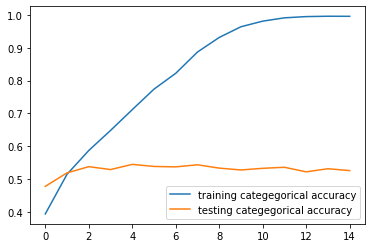

In [39]:
if TRAIN_MODEL:   
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['categoricalaccuracy'], label = 'training categegorical accuracy')
    ax.plot(history.history['val_categoricalaccuracy'], label = 'testing categegorical accuracy')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h3>Precision</h3>
<p></p>

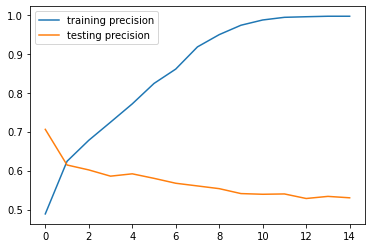

In [40]:
if TRAIN_MODEL:
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['precision'], label = 'training precision')
    ax.plot(history.history['val_precision'], label = 'testing precision')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h3>Recall</h3>
<p></p>

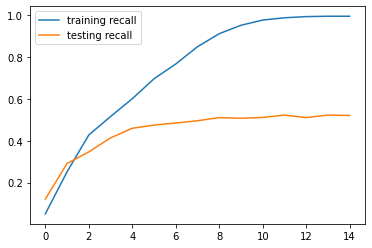

In [41]:
if TRAIN_MODEL:
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(history.history['recall'], label = 'training recall')
    ax.plot(history.history['val_recall'], label = 'testing recall')
    ax.legend()
    plt.show()
else:
    print('No data: model training skipped')

<h2>Evaluation</h2>

In [42]:
# Baseline - Random predictions
identity = np.eye(len(CLASSES))
baseline_labels=identity[np.random.choice(len(CLASSES), len(test_labels))]
print('done generating random predictions')

# Model Predictions
y_pred = model.predict(test_tokens)
print('done generating test predictions')

print('Classification Report - Baseline')
report_baseline = metrics.classification_report(test_labels.argmax(axis=1),
                                       baseline_labels.argmax(axis=1),
                                      target_names = CLASSES)
print(report_baseline)
print('Classification Report - Model')
report_model = metrics.classification_report(test_labels.argmax(axis=1),
                                       y_pred.argmax(axis=1),
                                      target_names = CLASSES)
print(report_model)

print('Confusion Matrix')
matrix = metrics.confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1))
print(CLASSES)
print(matrix)

done generating random predictions
done generating test predictions
Classification Report - Baseline
              precision    recall  f1-score   support

         CAG       0.34      0.32      0.33       561
         NAG       0.35      0.35      0.35       531
         OAG       0.31      0.32      0.31       494

    accuracy                           0.33      1586
   macro avg       0.33      0.33      0.33      1586
weighted avg       0.33      0.33      0.33      1586

Classification Report - Model
              precision    recall  f1-score   support

         CAG       0.45      0.46      0.46       561
         NAG       0.61      0.56      0.58       531
         OAG       0.52      0.55      0.54       494

    accuracy                           0.52      1586
   macro avg       0.53      0.52      0.52      1586
weighted avg       0.52      0.52      0.52      1586

Confusion Matrix
['CAG', 'NAG', 'OAG']
[[258 133 170]
 [154 297  80]
 [161  60 273]]


<h2>Running Predictions Using The Saved Model</h2>

In [0]:
def Load_Checkpoint(Model):
    
    latest_checkpoint = tf.train.latest_checkpoint('Model')
    #loaded_model = build_model_fullyconnected()
    
    print('Model build with random weights')
    #Model.evaluate(test_tokens, test_labels, verbose=2)
       
    Model.load_weights(latest_checkpoint)
    print('Weights loaded')
    #Model.evaluate(test_tokens, test_labels, verbose=2)
    
    return Model
    
def Model_Predictions(Model, Text_Array):
    inputs = Bertify(Text_Array)
    predicted_labels = Model.predict(inputs)
    label_indices = np.argmax(predicted_labels, axis=1)
    labels = [CLASSES[x] for x in label_indices]
    return labels

if LOAD_MODEL_AND_PREDICT:
    model = Load_Checkpoint(model)
    predictions = Model_Predictions(loaded_model, TEXT_TO_PREDICT)
    for text, prediction in zip(TEXT_TO_PREDICT, predictions):
        print(text)
        print(prediction)


Model build with random weights
Weights loaded
The pigs in office are abusing their power
CAG
That is a well reasoned point
NAG
You dont know what ur talking about and are speaking like a terrorist....
CAG
This is happening in BJP ruled state. Shame on the adminstration
CAG
